In [1]:
#As we dont have any GPU we will be using google collab for GPU usage
#Mout at drive 
import sys
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
#useful downloads
#!pip install bnlp_toolkit

In [3]:
#import packages

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sn
%matplotlib inline
import re
import sys
import warnings
import pandas as pd
import numpy as np
from sklearn import preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from bnlp.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
#read the data
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/dataset/bangla_comments_tokenized.csv')
df.tail()


,label,text,clean_text,tokenized_clean_text,tokenized_stem_text
43996,not bully,হিরো আলম এগা যাও,হিরো আলম এগিয়ে যাও,"['হিরো', 'আলম', 'এগিয়ে', 'যাও']","['হিরো', 'আলম', 'এগা', 'যাও']"
43997,not bully,হিরো আলম সাপোর্ট অসংখ্য ধন্যবাদ আপনা,হিরো আলমকে সাপোর্ট অসংখ্য ধন্যবাদ আপনাকে,"['হিরো', 'আলমকে', 'সাপোর্ট', 'অসংখ্য', 'ধন্যবা...","['হিরো', 'আলম', 'সাপোর্ট', 'অসংখ্য', 'ধন্যবাদ'..."
43998,not bully,হিরো ভাই এগা য়াও,হিরো ভাই এগিয়ে য়াও,"['হিরো', 'ভাই', 'এগিয়ে', 'য়াও']","['হিরো', 'ভাই', 'এগা', 'য়াও']"
43999,not bully,হুম ভাও তোমরা এগা যাও তোমা পিছনে আছি,হুম ভাও তোমরা এগিয়ে যাও তোমাদের পিছনে আছি,"['হুম', 'ভাও', 'তোমরা', 'এগিয়ে', 'যাও', 'তোমাদ...","['হুম', 'ভাও', 'তোমরা', 'এগা', 'যাও', 'তোমা', ..."
44000,not bully,হ্যালো তোমা সাথে আমা চ্যাট করবে,হ্যালো তোমাদের সাথে আমা চ্যাট করবে,"['হ্যালো', 'তোমাদের', 'সাথে', 'আমা', 'চ্যাট', ...","['হ্যালো', 'তোমা', 'সাথে', 'আমা', 'চ্যাট', 'কর..."


In [5]:
#rename  'not bully' to 'acceptable'
df['label'] = df['label'].replace({'not bully':'acceptable'})
df.head()

,label,text,clean_text,tokenized_clean_text,tokenized_stem_text
0,sexual,হালা পুত মদ খাওয় সময় রাত বেলা মদ খাই দিন বেল...,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দ...,"['হালার', 'পুত', 'মদ', 'খাওয়ার', 'সময়', 'রাত...","['হালা', 'পুত', 'মদ', 'খাওয়', 'সময়', 'রাত', ..."
1,acceptable,ঘরে শুট কেমন ক্যামেরা ছিল,ঘরে শুট কেমন ক্যামেরাতে ছিলেন,"['ঘরে', 'শুট', 'কেমন', 'ক্যামেরাতে', 'ছিলেন']","['ঘরে', 'শুট', 'কেমন', 'ক্যামেরা', 'ছিল']"
2,acceptable,অরে বাবা পাগল,অরে বাবা পাগল,"['অরে', 'বাবা', 'পাগল']","['অরে', 'বাবা', 'পাগল']"
3,acceptable,ক্যাপ্ট অফ বাংলাদেশ,ক্যাপ্টেন অফ বাংলাদেশ,"['ক্যাপ্টেন', 'অফ', 'বাংলাদেশ']","['ক্যাপ্ট', 'অফ', 'বাংলাদেশ']"
4,troll,পটকা মাছ,পটকা মাছ,"['পটকা', 'মাছ']","['পটকা', 'মাছ']"


In [6]:
#categorical Columns OneHotEncoder
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import OneHotEncoder
class My_encoder(BaseEstimator, TransformerMixin):
   
    def __init__(self,drop = 'first',sparse=False):
        self.encoder = OneHotEncoder(drop = drop,sparse = sparse)
        self.features_to_encode = []
        self.columns = []
    
    def fit(self,X_train,features_to_encode):
        
        data = X_train.copy()
        self.features_to_encode = features_to_encode
        data_to_encode = data[self.features_to_encode]
        self.columns = pd.get_dummies(data_to_encode,drop_first = True).columns
        self.encoder.fit(data_to_encode)
        return self.encoder
    
    def transform(self,X_test):
        
        data = X_test.copy()
        data.reset_index(drop = True,inplace =True)
        data_to_encode = data[self.features_to_encode]
        data_left = data.drop(self.features_to_encode,axis = 1)
        data_encoded = pd.DataFrame(self.encoder.transform(data_to_encode),columns = self.columns)
        
        return pd.concat([data_left,data_encoded],axis = 1)

In [7]:
#fill na values with zero
df = df.fillna(0)
df.head()

,label,text,clean_text,tokenized_clean_text,tokenized_stem_text
0,sexual,হালা পুত মদ খাওয় সময় রাত বেলা মদ খাই দিন বেল...,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দ...,"['হালার', 'পুত', 'মদ', 'খাওয়ার', 'সময়', 'রাত...","['হালা', 'পুত', 'মদ', 'খাওয়', 'সময়', 'রাত', ..."
1,acceptable,ঘরে শুট কেমন ক্যামেরা ছিল,ঘরে শুট কেমন ক্যামেরাতে ছিলেন,"['ঘরে', 'শুট', 'কেমন', 'ক্যামেরাতে', 'ছিলেন']","['ঘরে', 'শুট', 'কেমন', 'ক্যামেরা', 'ছিল']"
2,acceptable,অরে বাবা পাগল,অরে বাবা পাগল,"['অরে', 'বাবা', 'পাগল']","['অরে', 'বাবা', 'পাগল']"
3,acceptable,ক্যাপ্ট অফ বাংলাদেশ,ক্যাপ্টেন অফ বাংলাদেশ,"['ক্যাপ্টেন', 'অফ', 'বাংলাদেশ']","['ক্যাপ্ট', 'অফ', 'বাংলাদেশ']"
4,troll,পটকা মাছ,পটকা মাছ,"['পটকা', 'মাছ']","['পটকা', 'মাছ']"


In [8]:
# label encoding for output

sample_data = [2000,5000,10000,20000,30000,40000]

def label_encoding(category,bool):
  le = preprocessing.LabelEncoder()
  le.fit(category)
  encoded_labels = le.transform(category)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print("\n\t\t\t Label Encoding ","\nClass Names:",le.classes_)
    for i in sample_data:
      print(category[i],' ', encoded_labels[i],'\n')
    return labels

df.labels = label_encoding(df.label,True)


			 Label Encoding  
Class Names:--> ['acceptable' 'religious' 'sexual' 'threat' 'troll']
acceptable   0 

troll   4 

acceptable   0 

sexual   2 

sexual   2 

acceptable   0 



In [9]:
#confusion matrix

def conf_matrix(pred,classfier,directory,filename):
  predictions = pred
  y_pred = np.array(predictions)
  cm = confusion_matrix(y_test, y_pred) 
# Transform to df for easier plotting
  
  cm_df = pd.DataFrame(cm,
                       index = ['acceptable' ,'religious' ,'sexual', 'threat', 'troll'], 
                       columns = ['acceptable' ,'religious' ,'sexual', 'threat', 'troll'])
  plt.figure(figsize=(8,6))
  sn.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
  plt.title('\n'+classfier+'Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.xticks(rotation = 45)
  plt.yticks(rotation = 45)
  plt.savefig("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/result_analysis/"+directory+"/"+filename+".png")
  plt.show()
  plt.close()

In [10]:
#report generation

def report_generate(pred,classfier,directory,filename):
  report = pd.DataFrame(classification_report(y_true = y_test, y_pred = pred, output_dict=True)).transpose()
  report = report.rename(index={'0': 'acceptable','1':'religious','2':'sexual','3':'threat','4':'troll'})
  report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
  report=report.drop(["support"],axis=1)
  columns = ['precision','recall','f1-score']
  report.columns = columns
  plt = report.plot(kind='bar',figsize=(12,6))
  
  plot=plt.tick_params(rotation=40)
  plt.figure.savefig("/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/visualization/result_analysis/"+directory+"/"+filename+".png")
  
  return plot,report

In [11]:
#divide the model for trainning and testing
df.text=df.text.apply(str)
X = df.text.values
y = df.labels
categories = ['label_sexual','label_religious','label_troll','label_threat','label_acceptable']  #targeted labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

#checking...
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(30800,)
(13201,)
(30800,)
(13201,)


**MultinomialNB model with Tfidf using pipeline**

In [12]:
# Define a pipeline combining a text feature extractor with multi lable classifier
TFIDF_NB_pipeline = Pipeline([

                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=6000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

TFIDF_NB_pipeline.fit(X_train, y_train)
TFIDF_NB_pipeline_prediction = TFIDF_NB_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_NB_pipeline_prediction, y_test))

accuracy 0.7520642375577608


,precision,recall,f1-score
acceptable,75.84,87.53,81.27
religious,74.21,82.26,78.03
sexual,77.14,67.19,71.82
threat,88.31,44.60,59.27
troll,72.20,64.27,68.00
accuracy,75.21,75.21,75.21
macro avg,77.54,69.17,71.68
weighted avg,75.40,75.21,74.73


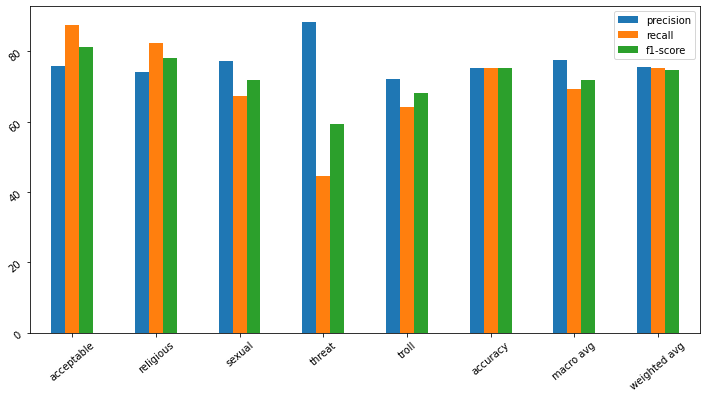

In [13]:
NB_report=report_generate(TFIDF_NB_pipeline_prediction,"NaiveBayes","MultiNB","multiNB_report")
NB_report[1]

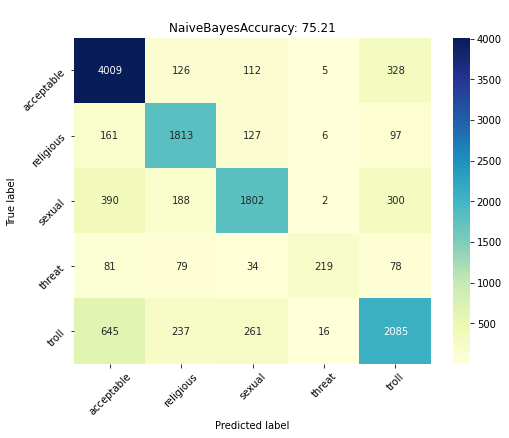

In [14]:
conf_matrix(TFIDF_NB_pipeline_prediction,"NaiveBayes","MultiNB","multinb_confusion")

**SGDclassifier model with TFIDF using pipeline**

In [15]:

TFIDF_SGD_pipeline = Pipeline([
                               
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=6000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, random_state=42, max_iter=90, tol=None)))
            ])


TFIDF_SGD_pipeline.fit(X_train, y_train)
TFIDF_SGD_pipeline_prediction = TFIDF_SGD_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_SGD_pipeline_prediction, y_test))


accuracy 0.7992576319975759


,precision,recall,f1-score
acceptable,73.80,92.73,82.19
religious,92.33,85.80,88.95
sexual,84.10,73.19,78.27
threat,86.67,58.25,69.67
troll,79.15,66.71,72.40
accuracy,79.93,79.93,79.93
macro avg,83.21,75.34,78.29
weighted avg,80.78,79.93,79.65


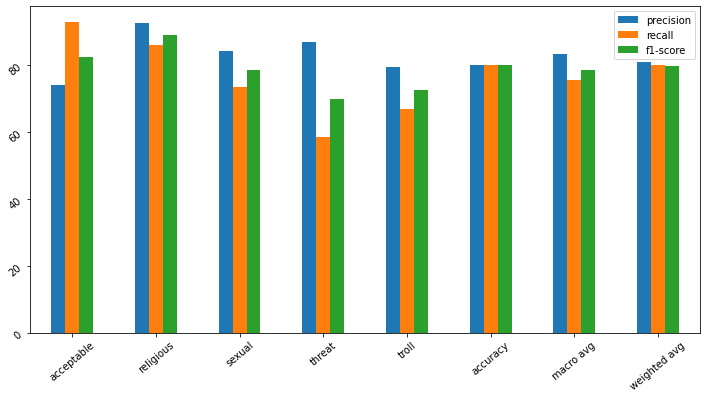

In [16]:
SGD_report=report_generate(TFIDF_SGD_pipeline_prediction,"SGD classifier","SGD","SGD_report")
SGD_report[1]

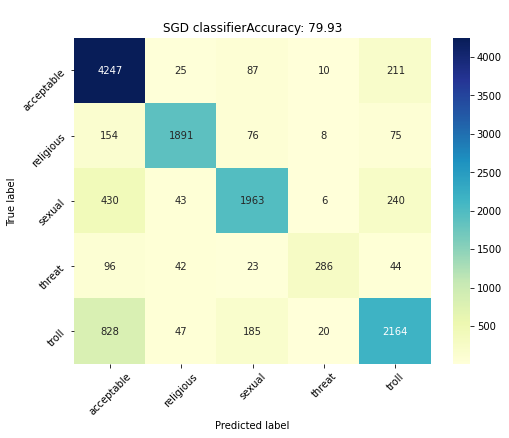

In [17]:
conf_matrix(TFIDF_SGD_pipeline_prediction,"SGD classifier","SGD","SGD_confusion")

**Logistic Regression model with TFIDF using pipeline**

In [18]:
TFIDF_LR_pipeline = Pipeline([

                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=6000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(LogisticRegression(C=0.7,random_state=42,tol=0.0001,max_iter=200)))
            ])

TFIDF_LR_pipeline.fit(X_train, y_train)
TFIDF_LR_pipeline_prediction = TFIDF_LR_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_LR_pipeline_prediction, y_test))



accuracy 0.7873645935913945


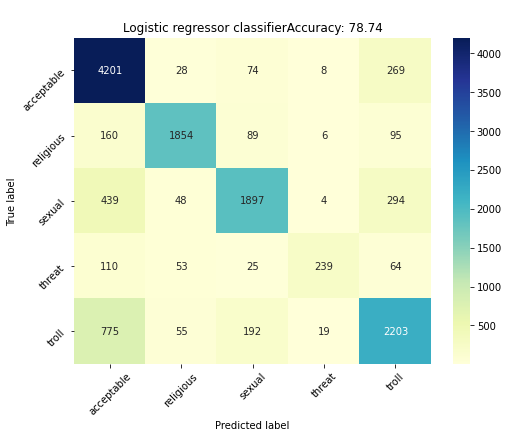

In [19]:
conf_matrix(TFIDF_LR_pipeline_prediction,"Logistic regressor classifier","Logistic Regression","LR_confusion")

,precision,recall,f1-score
acceptable,73.90,91.72,81.85
religious,90.97,84.12,87.41
sexual,83.31,70.73,76.51
threat,86.59,48.68,62.32
troll,75.32,67.91,71.42
accuracy,78.74,78.74,78.74
macro avg,82.02,72.63,75.90
weighted avg,79.48,78.74,78.40


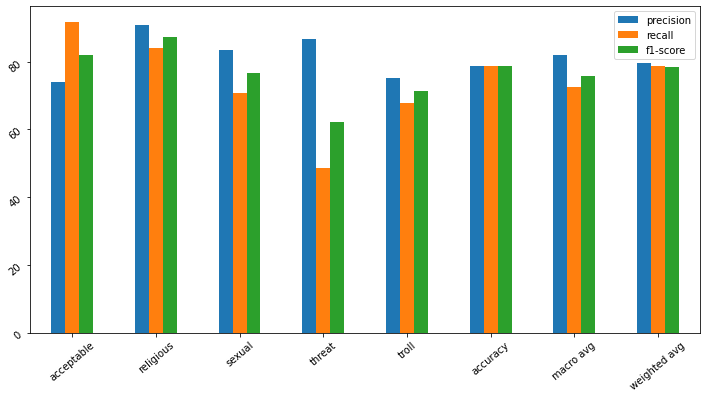

In [20]:
SGD_report=report_generate(TFIDF_LR_pipeline_prediction,"Logistic regressor classifier","Logistic Regression","LR_report")
SGD_report[1]

**RandomforrestClassifier model with TFIDF using pipeline**

In [21]:
from sklearn.ensemble import RandomForestClassifier
TFIDF_DT_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,max_features=6000,min_df=5,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=200)))
            ])


TFIDF_DT_pipeline.fit(X_train, y_train)
TFIDF_DT_pipeline_prediction = TFIDF_DT_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(TFIDF_DT_pipeline_prediction, y_test))



accuracy 0.8024392091508219


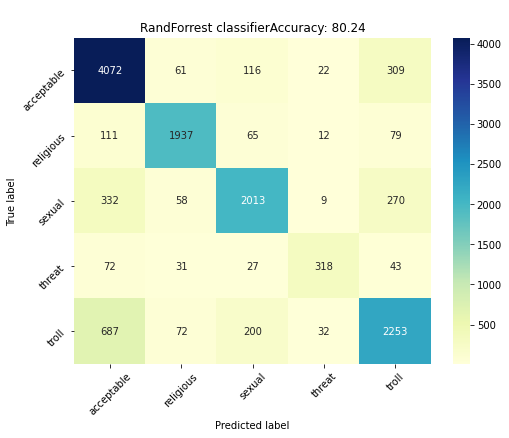

In [22]:
conf_matrix(TFIDF_DT_pipeline_prediction,"RandForrest classifier","Random forrest","RF_confusion")

,precision,recall,f1-score
acceptable,77.21,88.91,82.65
religious,89.72,87.89,88.79
sexual,83.15,75.06,78.89
threat,80.92,64.77,71.95
troll,76.27,69.45,72.70
accuracy,80.24,80.24,80.24
macro avg,81.45,77.21,79.00
weighted avg,80.41,80.24,80.07


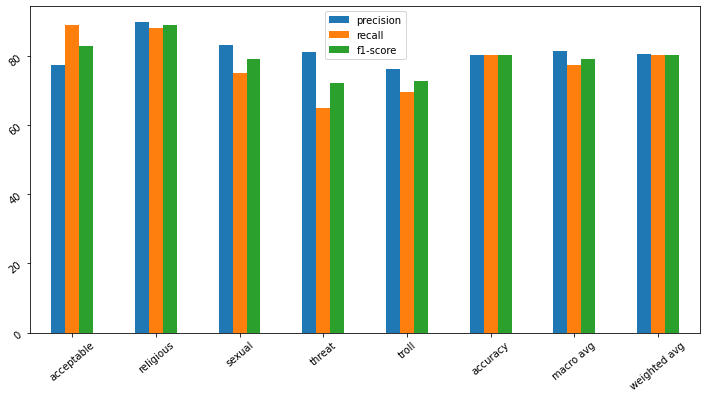

In [23]:
SGD_report=report_generate(TFIDF_DT_pipeline_prediction,"RandForrest classifier","Random forrest","RF_report")
SGD_report[1]

In [24]:
'''params = { "objective": "multi:softmax", 'num_class': 5, 'max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 200}

TFIDF_XGB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(tokenizer=lambda x: x.split(),lowercase=False,stop_words=stopwords,max_features=10000,min_df=5)),
                ('clf', OneVsRestClassifier(XGBClassifier(**params)))
            ])


TFIDF_XGB_pipeline.fit(X_train, y_train)
prediction = TFIDF_XGB_pipeline.predict(X_test)

print('accuracy %s' % accuracy_score(prediction, y_test))
print(classification_report(y_test, prediction, target_names=categories))




SyntaxError: ignored